## 1. Setup and Imports

In [15]:
import os
import json
import re
from pathlib import Path
from collections import Counter

import pdfplumber

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load PDF Files

In [16]:
DATA_DIR = Path('data')
OUTPUT_DIR = Path('processed_data')
OUTPUT_DIR.mkdir(exist_ok=True)

pdf_files = {
    'FM21-76': DATA_DIR / 'FM21-76_SurvivalManual.pdf',
    'FM3-05-70': DATA_DIR / 'fm3-05-70.pdf'
}

for name, path in pdf_files.items():
    if path.exists():
        print(f"Found: {name} ({path.stat().st_size / 1024 / 1024:.2f} MB)")
    else:
        print(f"Missing: {name}")

Found: FM21-76 (2.88 MB)
Found: FM3-05-70 (20.05 MB)


## 3. Extract Text from PDFs

We'll try multiple parsing methods and compare quality.

In [17]:
def extract_text_pdfplumber(pdf_path):
    pages = []
    pdf_path = Path(pdf_path)
    
    with pdfplumber.open(str(pdf_path)) as pdf:
        num_pages = len(pdf.pages)
        
        for i, page in enumerate(pdf.pages):
            text = page.extract_text()
            pages.append({
                'page_num': i + 1,
                'text': text if text else '',
                'char_count': len(text) if text else 0
            })
    
    return pages, num_pages

In [18]:
extracted_data = {}

# Define page ranges for each manual (other pages include not useful information)
page_ranges = {
    'FM21-76': (5, None),
    'FM3-05-70': (10, 661) 
}

for name, path in pdf_files.items():
    print(f"\nExtracting {name}...")
    try:
        pages, num_pages = extract_text_pdfplumber(path)
        
        start_page, end_page = page_ranges.get(name, (1, None))
        filtered_pages = []
        
        for page in pages:
            page_num = page['page_num']
            if page_num >= start_page:
                if end_page is None or page_num <= end_page:
                    filtered_pages.append(page)
        
        extracted_data[name] = {
            'pages': filtered_pages,
            'num_pages': len(filtered_pages),
            'source_file': str(path),
            'original_pages': num_pages,
            'page_range': f"{start_page}-{end_page if end_page else 'end'}"
        }
        print(f"Extracted {len(filtered_pages)} pages (from {num_pages} total, range: {start_page}-{end_page if end_page else 'end'})")
        
        for page in filtered_pages[:10]:
            if page['char_count'] > 100: 
                print(f"\n  Sample from page {page['page_num']}:")
                print(f"  {page['text'][:500]}...")
                break
    except Exception as e:
        print(f"Error: {e}")


Extracting FM21-76...
Extracted 229 pages (from 233 total, range: 5-end)

  Sample from page 5:
  FM 21-76 US ARMY SURVIVAL MANUAL Reprinted as permitted by U.S. Department of the Army
CHAPTER 1 - INTRODUCTION
This manual is based entirely on the keyword SURVIVAL. The letters in this word can help
guide you in your actions in any survival situation. Whenever faced with a survival
situation, remember the word SURVIVAL.
SURVIVAL ACTIONS
The following paragraphs expand on the meaning of each letter of the word survival. Study and
remember what each letter signifies because you may some day have...

Extracting FM3-05-70...
Extracted 229 pages (from 233 total, range: 5-end)

  Sample from page 5:
  FM 21-76 US ARMY SURVIVAL MANUAL Reprinted as permitted by U.S. Department of the Army
CHAPTER 1 - INTRODUCTION
This manual is based entirely on the keyword SURVIVAL. The letters in this word can help
guide you in your actions in any survival situation. Whenever faced with a survival
situation, 

## 4. EDA

In [19]:
summary_stats = []

for name, data in extracted_data.items():
    pages = data['pages']
    texts = [p['text'] for p in pages if p['text']]
    
    total_chars = sum(len(t) for t in texts)
    total_words = sum(len(t.split()) for t in texts)
    total_sentences = sum(len(sent_tokenize(t)) for t in texts if t)
    
    avg_chars_per_page = total_chars / len(pages)
    avg_words_per_page = total_words / len(pages)
    
    summary_stats.append({
        'Manual': name,
        'Total Pages': len(pages),
        'Total Characters': f"{total_chars:,}",
        'Total Words': f"{total_words:,}",
        'Total Sentences': f"{total_sentences:,}",
        'Avg Chars/Page': f"{avg_chars_per_page:.0f}",
        'Avg Words/Page': f"{avg_words_per_page:.0f}"
    })

summary_df = pd.DataFrame(summary_stats)
print("Stats")
print(summary_df.to_string(index=False))

Stats
   Manual  Total Pages Total Characters Total Words Total Sentences Avg Chars/Page Avg Words/Page
  FM21-76          229          511,373      88,517           5,988           2233            387
FM3-05-70          652          745,754     127,236          10,654           1144            195


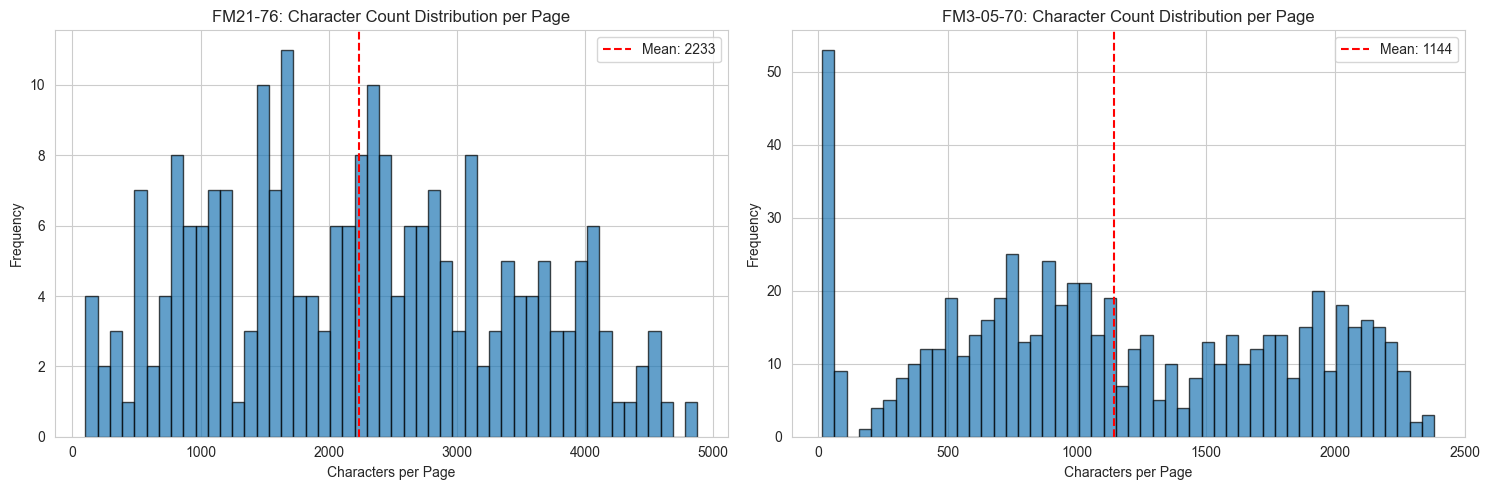

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for idx, (name, data) in enumerate(extracted_data.items()):
    char_counts = [p['char_count'] for p in data['pages']]
    
    axes[idx].hist(char_counts, bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{name}: Character Count Distribution per Page')
    axes[idx].set_xlabel('Characters per Page')
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(np.mean(char_counts), color='red', linestyle='--', 
                     label=f'Mean: {np.mean(char_counts):.0f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [21]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

for name, data in extracted_data.items():
    print(f"Vocabulary Analysis: {name}")
    
    all_text = ' '.join([p['text'] for p in data['pages'] if p['text']])
    
    words = word_tokenize(all_text.lower())
    words_clean = [w for w in words if w.isalpha() and w not in stop_words and len(w) > 3]
    
    word_freq = Counter(words_clean)
    top_20 = word_freq.most_common(20)
    
    print(f"\nTotal unique words: {len(word_freq):,}")
    print(f"\nTop 20 most frequent words:")
    for word, count in top_20:
        print(f"  {word:15s}: {count:4d}")
    print("\n")

Vocabulary Analysis: FM21-76

Total unique words: 6,762

Top 20 most frequent words:
  water          :  603
  army           :  467
  survival       :  467
  make           :  242
  manual         :  238
  reprinted      :  229
  permitted      :  229
  department     :  229
  page           :  229
  body           :  193
  food           :  191
  area           :  185
  also           :  181
  shelter        :  171
  plants         :  169
  fish           :  163
  raft           :  163
  must           :  160
  keep           :  159
  figure         :  159


Vocabulary Analysis: FM3-05-70

Total unique words: 6,762

Top 20 most frequent words:
  water          :  603
  army           :  467
  survival       :  467
  make           :  242
  manual         :  238
  reprinted      :  229
  permitted      :  229
  department     :  229
  page           :  229
  body           :  193
  food           :  191
  area           :  185
  also           :  181
  shelter        :  171
  plants  

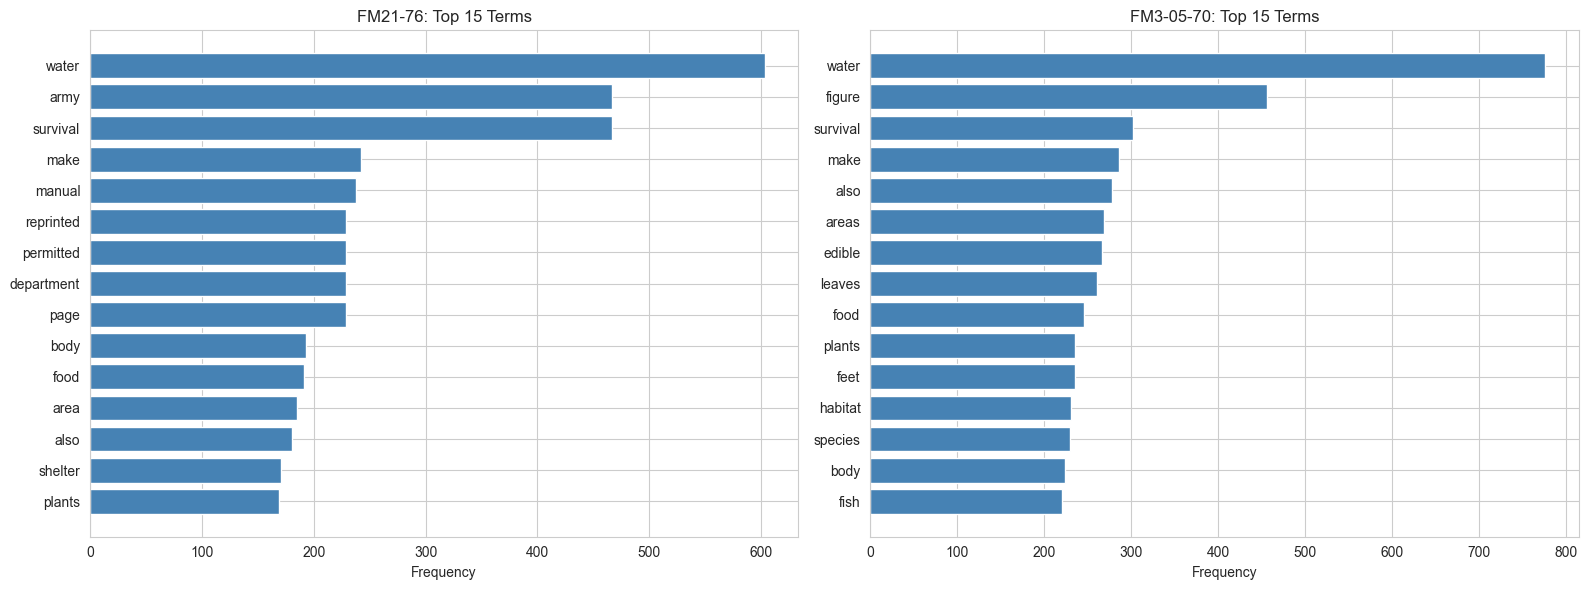

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (name, data) in enumerate(extracted_data.items()):
    all_text = ' '.join([p['text'] for p in data['pages'] if p['text']])
    words = word_tokenize(all_text.lower())
    words_clean = [w for w in words if w.isalpha() and w not in stop_words and len(w) > 3]
    word_freq = Counter(words_clean)
    top_15 = word_freq.most_common(15)
    
    words_list, counts = zip(*top_15)
    
    axes[idx].barh(range(len(words_list)), counts, color='steelblue')
    axes[idx].set_yticks(range(len(words_list)))
    axes[idx].set_yticklabels(words_list)
    axes[idx].set_xlabel('Frequency')
    axes[idx].set_title(f'{name}: Top 15 Terms')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

## 5. Text Cleaning and Preprocessing

In [51]:
def clean_text(text):
    """Clean and normalize text"""
    if not text:
        return ""
    
    # Remove manual-specific headers that appear at the start of pages
    # FM21-76: "US ARMY SURVIVAL MANUAL Reprinted as permitted by U.S. Department of the Army"
    text = re.sub(r'US ARMY SURVIVAL MANUAL Reprinted as permitted by U\.S\. Department of the Army\s*', '', text, flags=re.IGNORECASE)
    
    # Remove page headers/footers patterns
    # Common patterns: "FM 21-76", "FM 3-05.70", etc.
    text = re.sub(r'FM\s*\d+-?\d*\.?\d*', '', text, flags=re.IGNORECASE)
    
    # FM3-05-70: Remove ".70" that remains after FM removal
    text = re.sub(r'^\s*\.70\s*', '', text)
    text = re.sub(r'\s+\.70\s+', ' ', text)
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove excessive dashes/underscores
    text = re.sub(r'[-_]{3,}', '', text)
    
    text = text.strip()
    
    return text

for name, data in extracted_data.items():
    for page in data['pages']:
        page['text_clean'] = clean_text(page['text'])

In [52]:
sample_manual = list(extracted_data.keys())[0]
sample_page = None

for page in extracted_data[sample_manual]['pages']:
    if page['char_count'] > 2000:
        sample_page = page
        break

if sample_page:
    print(f"Sample from {sample_manual}, Page {sample_page['page_num']}")
    print("\nBefore preprocessing:")
    print(sample_page['text'][:1500])
    print("\nAfter preprocessing:")
    print(sample_page['text_clean'][:1500])

Sample from FM21-76, Page 5

Before preprocessing:
FM 21-76 US ARMY SURVIVAL MANUAL Reprinted as permitted by U.S. Department of the Army
CHAPTER 1 - INTRODUCTION
This manual is based entirely on the keyword SURVIVAL. The letters in this word can help
guide you in your actions in any survival situation. Whenever faced with a survival
situation, remember the word SURVIVAL.
SURVIVAL ACTIONS
The following paragraphs expand on the meaning of each letter of the word survival. Study and
remember what each letter signifies because you may some day have to make it work for you.
S -Size Up the Situation
If you are in a combat situation, find a place where you can conceal yourself from the enemy.
Remember, security takes priority. Use your senses of hearing, smell, and sight to get a feel for the
battlefield. What is the enemy doing? Advancing? Holding in place? Retreating? You will have to
consider what is developing on the battlefield when you make your survival plan.
Size Up Your Surroundings

## 6. Chunking Strategies

We'll create chunks using different strategies and compare them.

In [53]:
def chunk_by_pages(data, manual_name):
    """Strategy 1: One chunk per page"""
    chunks = []
    for page in data['pages']:
        if page['text_clean']:
            chunks.append({
                'chunk_id': f"{manual_name}_page_{page['page_num']}",
                'text': page['text_clean'],
                'source': manual_name,
                'page_num': page['page_num'],
                'chunk_method': 'page'
            })
    return chunks

def chunk_by_fixed_size(data, manual_name, chunk_size=1000, overlap=200):
    """Strategy 2: Fixed-size chunks with overlap"""
    chunks = []
    all_text = ' '.join([p['text_clean'] for p in data['pages'] if p['text_clean']])
    
    start = 0
    chunk_num = 0
    
    while start < len(all_text):
        end = start + chunk_size
        chunk_text = all_text[start:end]
        
        if chunk_text.strip():
            chunks.append({
                'chunk_id': f"{manual_name}_fixed_{chunk_num}",
                'text': chunk_text,
                'source': manual_name,
                'chunk_method': 'fixed_size',
                'char_start': start,
                'char_end': end
            })
            chunk_num += 1
        
        start = end - overlap
    
    return chunks

def chunk_by_sentences(data, manual_name, sentences_per_chunk=10):
    """Strategy 3: Semantic chunking by sentences"""
    chunks = []
    all_text = ' '.join([p['text_clean'] for p in data['pages'] if p['text_clean']])
    
    sentences = sent_tokenize(all_text)
    
    for i in range(0, len(sentences), sentences_per_chunk):
        chunk_sentences = sentences[i:i + sentences_per_chunk]
        chunk_text = ' '.join(chunk_sentences)
        
        if chunk_text.strip():
            chunks.append({
                'chunk_id': f"{manual_name}_sent_{i // sentences_per_chunk}",
                'text': chunk_text,
                'source': manual_name,
                'chunk_method': 'sentence',
                'sentence_start': i,
                'sentence_end': i + sentences_per_chunk
            })
    
    return chunks

In [54]:
all_chunks = {
    'page': [],
    'fixed_size': [],
    'sentence': []
}

for name, data in extracted_data.items():
    print(f"\nChunking {name}...")
    
    page_chunks = chunk_by_pages(data, name)
    all_chunks['page'].extend(page_chunks)
    print(f"  Page chunks: {len(page_chunks)}")
    
    fixed_chunks = chunk_by_fixed_size(data, name, chunk_size=1000, overlap=200)
    all_chunks['fixed_size'].extend(fixed_chunks)
    print(f"  Fixed-size chunks: {len(fixed_chunks)}")
    
    sent_chunks = chunk_by_sentences(data, name, sentences_per_chunk=10)
    all_chunks['sentence'].extend(sent_chunks)
    print(f"  Sentence chunks: {len(sent_chunks)}")

print("\n")
for method, chunks in all_chunks.items():
    avg_length = np.mean([len(c['text']) for c in chunks])
    print(f"{method:15s}: {len(chunks):4d} chunks (avg {avg_length:.0f} chars)")


Chunking FM21-76...
  Page chunks: 229
  Fixed-size chunks: 615
  Sentence chunks: 576

Chunking FM3-05-70...
  Page chunks: 652
  Fixed-size chunks: 925
  Sentence chunks: 1001


page           :  881 chunks (avg 1397 chars)
fixed_size     : 1540 chunks (avg 999 chars)
sentence       : 1577 chunks (avg 780 chars)
  Sentence chunks: 1001


page           :  881 chunks (avg 1397 chars)
fixed_size     : 1540 chunks (avg 999 chars)
sentence       : 1577 chunks (avg 780 chars)


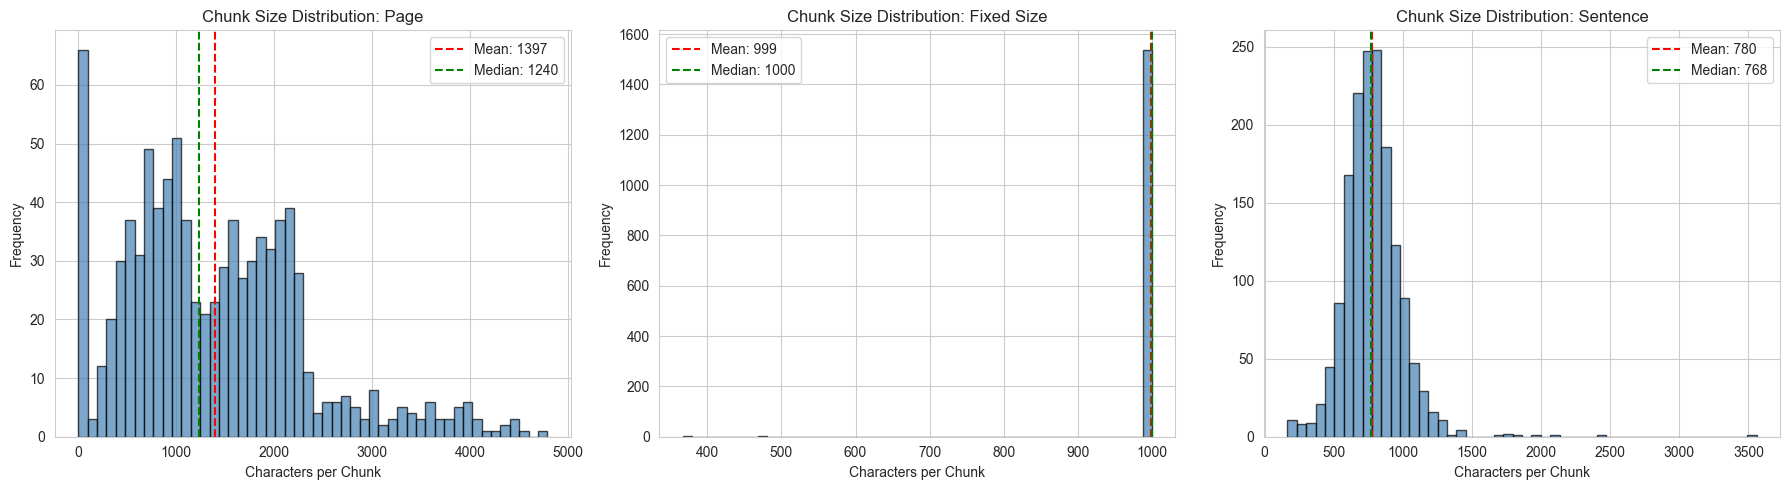

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (method, chunks) in enumerate(all_chunks.items()):
    chunk_lengths = [len(c['text']) for c in chunks]
    
    axes[idx].hist(chunk_lengths, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_title(f'Chunk Size Distribution: {method.replace("_", " ").title()}')
    axes[idx].set_xlabel('Characters per Chunk')
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(np.mean(chunk_lengths), color='red', linestyle='--',
                     label=f'Mean: {np.mean(chunk_lengths):.0f}')
    axes[idx].axvline(np.median(chunk_lengths), color='green', linestyle='--',
                     label=f'Median: {np.median(chunk_lengths):.0f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [56]:

print("\nSample chunks")

for method, chunks in all_chunks.items():
    print(f"Method: {method.upper()}")
    
    sample_chunk = chunks[100]
    
    print(f"Chunk ID: {sample_chunk['chunk_id']}")
    print(f"Length: {len(sample_chunk['text'])} characters")
    print(f"\nContent preview:")
    print(sample_chunk['text'][:500])
    print("...")


Sample chunks
Method: PAGE
Chunk ID: FM21-76_page_105
Length: 2127 characters

Content preview:
• Papaya (Carica species) • Sugarcane (Saccharum officinarum) • Taro (Colocasia species) DESERT ZONE FOOD PLANTS • Acacia (Acacia farnesiana) • Agave (Agave species) • Cactus (various species) • Date palm (Phoenix dactylifera) • Desert amaranth (Amaranths palmeri) Seaweeds One plant you should never overlook is seaweed. It is a form of marine algae found on or near ocean shores. There are also some edible freshwater varieties. Seaweed is a valuable source of iodine, other minerals, and vitamin C
...
Method: FIXED_SIZE
Chunk ID: FM21-76_fixed_100
Length: 1000 characters

Content preview:
m by dipping him in a cool stream. If one is not available, douse the victim with urine, water, or at the very least, apply cool wet com-presses to all the joints, especially the neck, armpits, and crotch. Be sure to wet the victim's head. Heat loss through the scalp is great. Administer IVs and provide drin

## 7. Save Processed Data

Save chunks in different formats for RAG pipeline.

In [57]:
for method, chunks in all_chunks.items():
    output_file = OUTPUT_DIR / f'chunks_{method}.json'
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(chunks, f, indent=2, ensure_ascii=False)
    print(f"Saved {len(chunks)} chunks to {output_file}")
    
    df = pd.DataFrame(chunks)
    csv_file = OUTPUT_DIR / f'chunks_{method}.csv'
    df.to_csv(csv_file, index=False, encoding='utf-8')
    print(f"Saved CSV to {csv_file}")

Saved 881 chunks to processed_data\chunks_page.json
Saved CSV to processed_data\chunks_page.csv
Saved 1540 chunks to processed_data\chunks_fixed_size.json
Saved CSV to processed_data\chunks_fixed_size.csv
Saved 1577 chunks to processed_data\chunks_sentence.json
Saved CSV to processed_data\chunks_sentence.csv


In [58]:
metadata = {
    'extraction_date': pd.Timestamp.now().isoformat(),
    'source_files': {name: str(path) for name, path in pdf_files.items()},
    'chunking_strategies': {
        'page': {
            'description': 'One chunk per page',
            'total_chunks': len(all_chunks['page']),
            'avg_chunk_size': int(np.mean([len(c['text']) for c in all_chunks['page']]))
        },
        'fixed_size': {
            'description': 'Fixed-size chunks with 200 char overlap',
            'chunk_size': 1000,
            'overlap': 200,
            'total_chunks': len(all_chunks['fixed_size']),
            'avg_chunk_size': int(np.mean([len(c['text']) for c in all_chunks['fixed_size']]))
        },
        'sentence': {
            'description': '10 sentences per chunk',
            'sentences_per_chunk': 10,
            'total_chunks': len(all_chunks['sentence']),
            'avg_chunk_size': int(np.mean([len(c['text']) for c in all_chunks['sentence']]))
        }
    },
    'corpus_stats': summary_stats
}

metadata_file = OUTPUT_DIR / 'metadata.json'
with open(metadata_file, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"Saved metadata to {metadata_file}")

Saved metadata to processed_data\metadata.json


## Check the created files

In [59]:
print("\nFiles created:")
for file in OUTPUT_DIR.glob('*'):
    size = file.stat().st_size / 1024
    print(f"  {file.name:30s} ({size:8.1f} KB)")


Files created:
  chunks_fixed_size.csv          (  1594.9 KB)
  chunks_fixed_size.json         (  1779.9 KB)
  chunks_page.csv                (  1241.4 KB)
  chunks_page.json               (  1330.2 KB)
  chunks_sentence.csv            (  1283.2 KB)
  chunks_sentence.json           (  1484.9 KB)
  metadata.json                  (     1.2 KB)
